In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import inv, norm
import pandas as pd
# from filterpy.kalman import KalmanFilter
from kalman import KalmanFilter
import os
import filter

import filter 
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import data_clean as dc 
from kalman import KalmanFilter

# kalman - original 
doesn't work

In [292]:
import cleaner

parent = '.data'
data_dict = cleaner.clean_dict(cleaner.load_data(parent, exclude_test=["PVS 7", "PVS 8"], exclude_val=["PVS 9"]))

In [293]:
def build_z_dash(df, type="train", road="good_road_left"):
    """
    Builds a 1 column dataset from the given dictionary of dataframes
    timestamp
    latitude
    longitude
    elevation
    acc_x_dash_smooth
    acc_y_dash_smooth
    acc_z_dash_smooth

    :param df: dataframe
    :param type: string

    :return: dataframe with only the acc_z_dash column
    """
    result = None
    lengths = []
    for folder in df[type]["gps_mpu_left"].keys():
        pvsi = df[type]["gps_mpu_left"][folder]
        labels = df[type]["labels"][folder][road]
        indices = labels[labels == 1].index

        new_data = pvsi.loc[indices]
        lengths.append(len(new_data))

        if result is None:
            result = new_data
        else:
            # append on the same column
            result = pd.concat([result, new_data], axis=0)

    return result, lengths
    


def build_gps_data(df, type="train"):
    """
    Builds a 6 column dataset from the given dataframe

    :param df: dataframe
    :param type: string

    :return: dataframe with only the acc_z_dash column
    :return: list of lengths
    """
    result = {}
    for folder in df[type]["gps_mpu_left"].keys():
        # pvsi = df[type]["gps_mpu_left"][folder][["timestamp", "meters_latitude", "meters_longitude", "acc_x_dash_smooth", "acc_y_dash_smooth", "acc_z_dash_smooth"]]
        pvsi = df[type]["gps_mpu_left"][folder][["timestamp", "meters_latitude", "meters_longitude", "acc_x_dash", "acc_y_dash", "acc_z_dash"]]
        elevation = df[type]["t_gps"][folder][["timestamp", "meters_elevation"]]

        # merge the two dataframes on timestamp then remove timestamp
        pvsi = pd.merge(pvsi, elevation, on="timestamp")
        pvsi = pvsi.drop(columns=["timestamp"])

        result[folder] = pvsi
    return result


train_dict = {
    "good": build_z_dash(data_dict, type="train", road="good_road_left"),
    "regular": build_z_dash(data_dict, type="train", road="regular_road_left"),
    "bad": build_z_dash(data_dict, type="train", road="bad_road_left")
}

test_dict = {
    "good": build_z_dash(data_dict, type="test", road="good_road_left"),
    "regular": build_z_dash(data_dict, type="test", road="regular_road_left"),
    "bad": build_z_dash(data_dict, type="test", road="bad_road_left")
}

filter.add_smoothed_cols(data_dict, window=200)
filter.add_diff_cols(data_dict)

kal_data = build_gps_data(data_dict, type="train")
print(kal_data)
#print((data_dict["train"]["t_gps"]["PVS 1"]))

{'PVS 3':      meters_latitude  meters_longitude  acc_x_dash  acc_y_dash  acc_z_dash  \
0      -1.268119e-07      7.449771e-07   -0.041539   -0.015143    9.807967   
1      -1.262570e-07      2.017052e-06    0.000359   -0.066619    9.791207   
2      -9.777217e-07      3.665824e-06   -0.033160   -0.001975    9.865428   
3      -1.290121e-06      4.806416e-06   -0.042736   -0.006764    9.843880   
4      -1.422826e-06      5.346613e-06   -0.017597    0.041120    9.813952   
..               ...               ...         ...         ...         ...   
151     1.091661e-02     -9.782956e-03    0.588136   -0.239001    8.731773   
152     1.111684e-02     -9.844316e-03   -0.125336   -0.580175    9.813952   
153     1.131583e-02     -9.906315e-03    0.984376   -0.770514   11.103230   
154     1.151339e-02     -9.967376e-03   -0.296522   -0.241395    9.898946   
155     1.170930e-02     -1.002827e-02    0.619260   -0.832763    9.283637   

     meters_elevation  
0            3.278475  
1    

In [294]:
kal_data_test = kal_data.copy()
kal_data_test['PVS 1']['acc_z_dash']  = kal_data_test['PVS 1']['acc_z_dash'] - kal_data_test['PVS 1']['acc_z_dash'].mean()

In [295]:
kal_data['PVS 3']


Q = np.eye(9) * 0.1
R = np.eye(6) * 1000
dt = .1
F = np.array(  [[1,0,0,dt,0,0,0,0,0],
                [0,1,0,0,dt,0,0,0,0],
                [0,0,1,0,0,dt,0,0,0],
                [0,0,0,1,0,0,dt,0,0],
                [0,0,0,0,1,0,0,dt,0],
                [0,0,0,0,0,1,0,0,dt],
                [0,0,0,0,0,0,1,0,0],
                [0,0,0,0,0,0,0,1,0],
                [0,0,0,0,0,0,0,0,1]])

G = np.ones((9,9))
# initial state
x0 = np.zeros(9)
P0 = 1e5 * Q
#P0 = 1e-1 * Q
# z = kal_data['PVS 1'][['meters_latitude', 'meters_longitude', 'meters_elevation', 'acc_x_dash_smooth','acc_y_dash_smooth', 'acc_z_dash_smooth']].to_numpy().T
z = kal_data_test['PVS 1'][['meters_latitude', 'meters_longitude', 'meters_elevation', 'acc_x_dash','acc_y_dash', 'acc_z_dash']].to_numpy().T
# z = kal_data["PVS 1"].to_numpy().T
# print(kal_data["PVS 1"].columns)
tsteps = 1000


H = np.zeros((6, 9))
for i in range(3):
    H[i, i] = 1
    H[i + 3, i + 6] = 0

print(H)

# control u
u = np.zeros(9)
# u[-1] = -.98

kf = KalmanFilter(F, Q, H, R, G, u)
est = kf.estimate(x0, P0, z)

[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


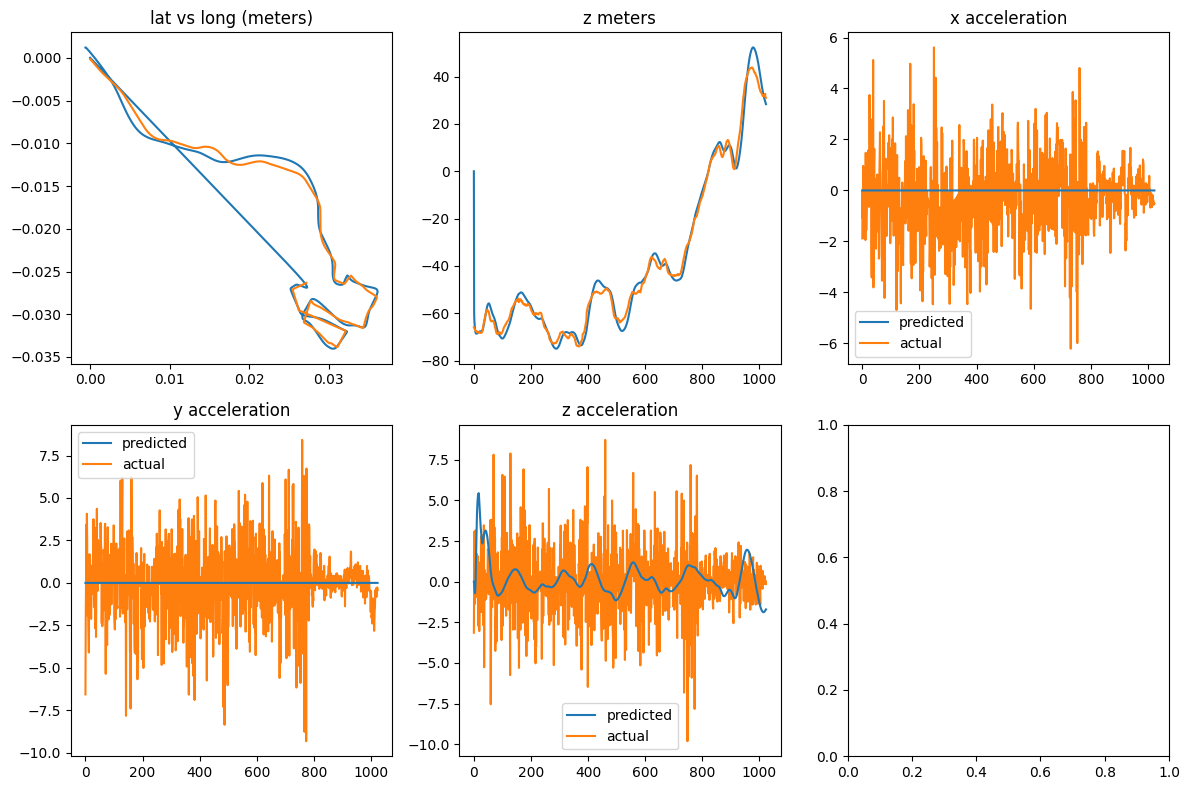

In [296]:
# compare plots
fig, ax = plt.subplots(2,3,figsize=(12,8))

# plot latitude/longitude
ax[0,0].plot(est[0], est[1])
ax[0,0].plot(z[0], z[1])
ax[0,0].set_title('lat vs long (meters)')

# plot z position
x = range(est.shape[1])
ax[0,1].plot(x, est[2])
ax[0,1].plot(x, z[2])
ax[0,1].set_title('z meters')

# plot acceleration
ax[0,2].plot(x, est[6], label='predicted')
ax[0,2].plot(x, z[3], label='actual', zorder=0)
ax[0,2].set_title('x acceleration')
ax[0,2].legend()

# plot acceleration
ax[1,0].plot(x, est[7], label='predicted')
ax[1,0].plot(x, z[4], label='actual', zorder=0)
ax[1,0].set_title('y acceleration')
ax[1,0].legend()

# plot acceleration
ax[1,1].plot(x, est[8], label='predicted')
ax[1,1].plot(x, z[5], label='actual', zorder=0)
ax[1,1].set_title('z acceleration')
ax[1,1].legend()

plt.tight_layout()
plt.show()


# kalman without cleaned data
works! 

In [310]:
# load data
data = cleaner.load_data(parent, exclude_test=["PVS 7", "PVS 8"], exclude_val=["PVS 9"])

In [311]:
data['train']['t_gps']['PVS 1']

,timestamp,latitude,longitude,elevation,accuracy,bearing,speed_meters_per_second,satellites,provider,hdop,vdop,pdop,geoidheight,ageofdgpsdata,dgpsid,activity,battery,annotation,distance_meters,elapsed_time_seconds
0,1.577219e+09,-27.717812,-51.098895,948.770836,24.0,159.73294,0.053275,0,gps,0.8,1.7,1.9,3.6,NaN,NaN,NaN,87,NaN,0.000000,0.0
1,1.577219e+09,-27.717818,-51.098840,970.378820,12.0,NaN,0.000000,12,gps,0.8,1.5,1.7,3.6,NaN,NaN,NaN,87,NaN,5.442520,2.0
2,1.577219e+09,-27.717832,-51.098871,989.374267,4.0,NaN,0.000000,13,gps,0.8,1.6,1.8,3.6,NaN,NaN,NaN,86,NaN,3.404871,5.0
3,1.577219e+09,-27.717833,-51.098867,988.439139,4.0,NaN,0.000000,14,gps,0.8,1.7,1.9,3.6,NaN,NaN,NaN,86,NaN,0.421733,1.0
4,1.577219e+09,-27.717835,-51.098873,987.668730,4.0,NaN,0.000000,14,gps,0.8,1.6,1.8,3.6,NaN,NaN,NaN,86,NaN,0.574281,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1462,1.577220e+09,-27.717778,-51.099069,980.865571,4.0,130.51640,0.017391,16,gps,0.8,1.3,1.5,3.6,NaN,NaN,NaN,81,NaN,0.176010,1.0
1463,1.577220e+09,-27.717773,-51.099072,981.469505,6.0,130.51602,0.033592,16,gps,0.8,1.3,1.5,3.6,NaN,NaN,NaN,81,NaN,0.644347,1.0
1464,1.577220e+09,-27.717773,-51.099078,979.980588,6.0,194.52164,0.761983,16,gps,0.9,1.3,1.5,3.6,NaN,NaN,NaN,81,NaN,0.614420,1.0
1465,1.577220e+09,-27.717777,-51.099073,979.903556,6.0,195.58694,0.054153,16,gps,0.8,1.3,1.5,3.6,NaN,NaN,NaN,81,NaN,0.645030,1.0


In [312]:
# select data
df = data['train']['gps_mpu_left']['PVS 1']

# average acceleration 
acc_x_cols = ['acc_x_dashboard', 'acc_x_above_suspension', 'acc_x_below_suspension']
acc_y_cols = ['acc_y_dashboard', 'acc_y_above_suspension', 'acc_y_below_suspension']
acc_z_cols = ['acc_z_dashboard', 'acc_z_above_suspension', 'acc_z_below_suspension']

df['acc_x'] = df[acc_x_cols].mean(axis=1)
df['acc_y'] = df[acc_y_cols].mean(axis=1)
df['acc_z'] = df[acc_z_cols].mean(axis=1)

# normalize z acc
df['acc_z'] = df['acc_z'] - df['acc_z'].mean()

# merge elevation data in 
cols = ['latitude', 'longitude', 'acc_x', 'acc_y', 'acc_z']
df = data['train']['gps_mpu_left']['PVS 1'][cols].merge(data['train']['t_gps']['PVS 1'][['latitude', 'longitude', 'elevation']], 'left', on=['latitude', 'longitude'])

In [313]:
# convert the coordinates to meters 
from geopy.distance import geodesic
reference_point = (df['latitude'].iloc[0], df['longitude'].iloc[0])
x_diffs = [geodesic((df['latitude'].iloc[0], df['longitude'].iloc[i]), (df['latitude'].iloc[i], df['longitude'].iloc[i])).meters for i in range(len(df)-1)]
x_diffs.append(None)

y_diffs = [geodesic((df['latitude'].iloc[i], df['longitude'].iloc[0]), (df['latitude'].iloc[i], df['longitude'].iloc[i])).meters for i in range(len(df)-1)]
y_diffs.append(None)

In [314]:
# add to dataframe
df['lat_m'] = x_diffs
df['long_m'] = y_diffs
df.dropna(inplace=True)

In [315]:
df

,latitude,longitude,acc_x,acc_y,acc_z,elevation,lat_m,long_m
0,-27.717841,-51.098865,0.239180,0.171079,0.020464,985.245045,0.000000,0.000000
1,-27.717841,-51.098865,0.266314,0.186641,0.001709,985.245045,0.000000,0.000000
2,-27.717841,-51.098865,0.231997,0.197016,0.040016,985.245045,0.000000,0.000000
3,-27.717841,-51.098865,0.230401,0.189035,0.017670,985.245045,0.000000,0.000000
4,-27.717841,-51.098865,0.246761,0.187439,0.061564,985.245045,0.000000,0.000000
...,...,...,...,...,...,...,...,...
144030,-27.717777,-51.099070,-0.680992,-0.229152,-0.137155,979.779629,7.140333,20.163527
144031,-27.717777,-51.099070,-0.521378,-0.187652,-0.147929,979.779629,7.140333,20.163527
144032,-27.717777,-51.099070,-0.623531,-0.400736,-0.041387,979.779629,7.140333,20.163527
144033,-27.717777,-51.099070,-0.400072,-0.147749,0.090294,979.779629,7.140333,20.163527


In [316]:
Q = np.eye(9) * 0.1
R = np.eye(6) * 1000
dt = .1
F = np.array(  [[1,0,0,dt,0,0,0,0,0],
                [0,1,0,0,dt,0,0,0,0],
                [0,0,1,0,0,dt,0,0,0],
                [0,0,0,1,0,0,dt,0,0],
                [0,0,0,0,1,0,0,dt,0],
                [0,0,0,0,0,1,0,0,dt],
                [0,0,0,0,0,0,1,0,0],
                [0,0,0,0,0,0,0,1,0],
                [0,0,0,0,0,0,0,0,1]])

G = np.ones((9,9))
# initial state
x0 = np.zeros(9)
P0 = 1e5 * Q
#P0 = 1e-1 * Q
# z = kal_data['PVS 1'][['meters_latitude', 'meters_longitude', 'meters_elevation', 'acc_x_dash_smooth','acc_y_dash_smooth', 'acc_z_dash_smooth']].to_numpy().T
# z = kal_data_test['PVS 1'][['meters_latitude', 'meters_longitude', 'meters_elevation', 'acc_x_dash','acc_y_dash', 'acc_z_dash']].to_numpy().T
# z = kal_data["PVS 1"].to_numpy().T
z = df[['lat_m', 'long_m', 'elevation', 'acc_x', 'acc_y', 'acc_z']].to_numpy().T
# print(kal_data["PVS 1"].columns)
tsteps = 1000


H = np.zeros((6, 9))
for i in range(3):
    H[i, i] = 1
    H[i + 3, i + 6] = 1

print(H)

# control u
u = np.zeros(9)
# u[-1] = -.98

kf = KalmanFilter(F, Q, H, R, G, u)
est = kf.estimate(x0, P0, z)

[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]


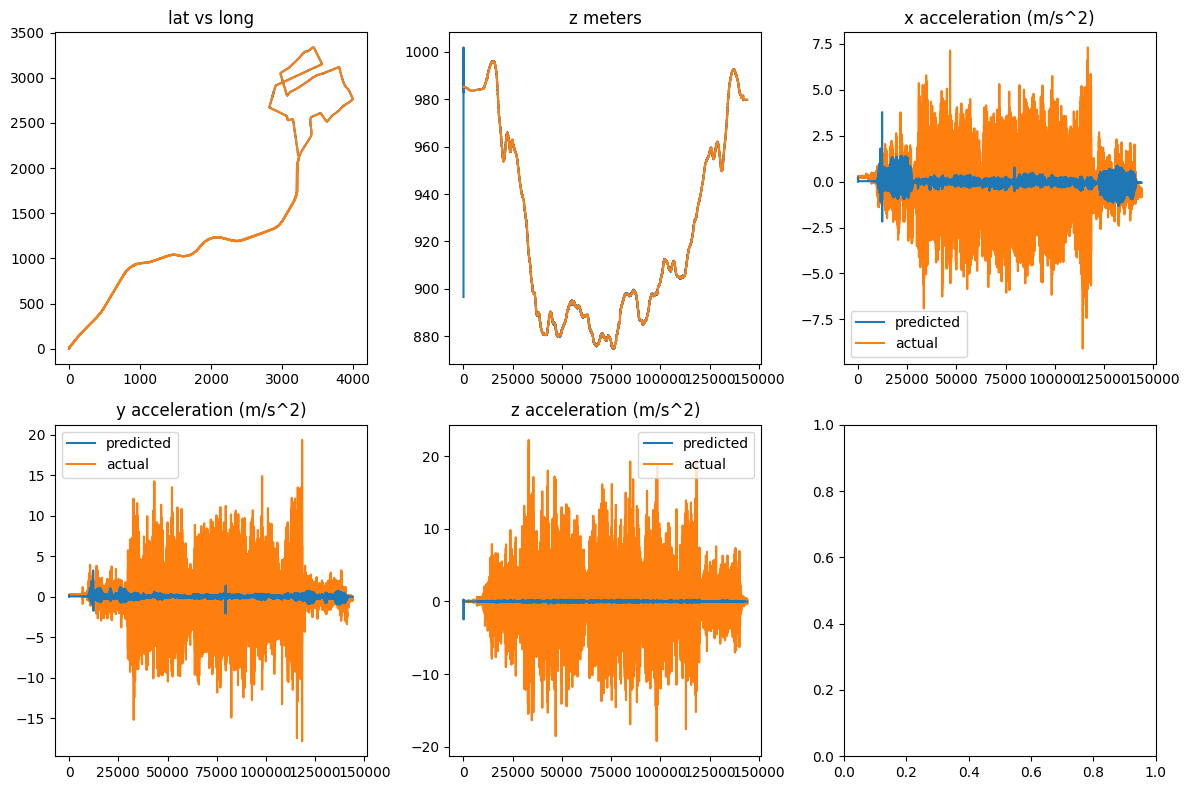

In [317]:
# compare plots
fig, ax = plt.subplots(2,3,figsize=(12,8))
x = range(est.shape[1])

# plot latitude/longitude
ax[0,0].plot(est[0, 10:], est[1, 10:])
ax[0,0].plot(z[0], z[1])
ax[0,0].set_title('lat vs long')
# ax[0,0].set_ylim(-55,-50)

# plot z position
ax[0,1].plot(x[1:], est[2,1:])
ax[0,1].plot(x[1:], z[2,1:])
ax[0,1].set_title('z meters')

# plot acceleration
ax[0,2].plot(x, est[6], label='predicted')
ax[0,2].plot(x, z[3], label='actual', zorder=0)
ax[0,2].set_title('x acceleration (m/s^2)')
ax[0,2].legend()

# plot acceleration
ax[1,0].plot(x, est[7], label='predicted')
ax[1,0].plot(x, z[4], label='actual', zorder=0)
ax[1,0].set_title('y acceleration (m/s^2)' )
ax[1,0].legend()
# ax[1,0].set_xlim(50000, 50100)

# plot acceleration
ax[1,1].plot(x, est[8], label='predicted')
ax[1,1].plot(x, z[5], label='actual', zorder=0)
ax[1,1].set_title('z acceleration (m/s^2)')
ax[1,1].legend()
# ax[1,1].set_xlim(50000, 50100)

plt.tight_layout()
plt.show()


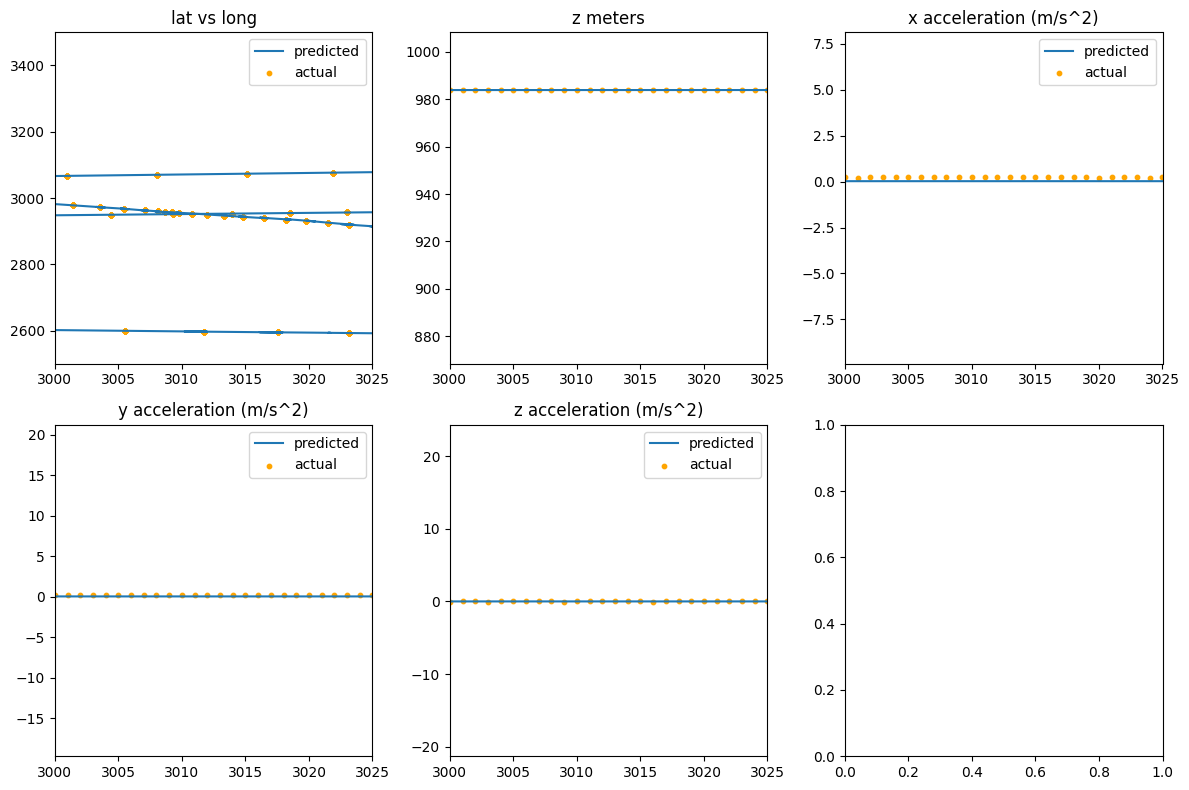

In [326]:
# zoomed in plots
# compare plots
fig, ax = plt.subplots(2,3,figsize=(12,8))
x = range(est.shape[1])

# plot latitude/longitude
ax[0,0].plot(est[0, 10:], est[1, 10:], label='predicted')
ax[0,0].scatter(z[0], z[1], s=10, c='orange', label='actual', zorder=0)
ax[0,0].set_title('lat vs long')
ax[0,0].legend()
ax[0,0].set_xlim(3000, 3025)
ax[0,0].set_ylim(2500,3500)

# plot z position
ax[0,1].plot(x[1:], est[2,1:])
ax[0,1].scatter(x[1:], z[2,1:], s=10, c='orange')
ax[0,1].set_title('z meters')
ax[0,1].set_xlim(3000, 3025)
# ax[0,1].set_ylim(2500,3500)

# plot acceleration
ax[0,2].plot(x, est[6], label='predicted')
ax[0,2].scatter(x, z[3], label='actual', zorder=0, s=10, c='orange')
ax[0,2].set_title('x acceleration (m/s^2)')
ax[0,2].legend()
ax[0,2].set_xlim(3000, 3025)
# ax[0,2].set_ylim(2500,3500)

# plot acceleration
ax[1,0].plot(x, est[7], label='predicted')
ax[1,0].scatter(x, z[4], label='actual', zorder=0, s=10, c='orange')
ax[1,0].set_title('y acceleration (m/s^2)' )
ax[1,0].legend()
ax[1,0].set_xlim(3000, 3025)
# ax[1,0].set_ylim(2500,3500)

# plot acceleration
ax[1,1].plot(x, est[8], label='predicted')
ax[1,1].scatter(x, z[5], label='actual', zorder=0, s=10, c='orange')
ax[1,1].set_title('z acceleration (m/s^2)')
ax[1,1].legend()
ax[1,1].set_xlim(3000, 3025)
# ax[1,1].set_ylim(2500,3500)
# ax[1,1].set_xlim(50000, 50100)

plt.tight_layout()
plt.show()
